## Plotting Kernel Density Estimate values for more than one dataset on the same plot

In [1]:
import numpy as np
import plotly as py
import plotly.graph_objects as go
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV, LeaveOneOut
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

#set pyplot to notebook mode
py.offline.init_notebook_mode(connected=True)

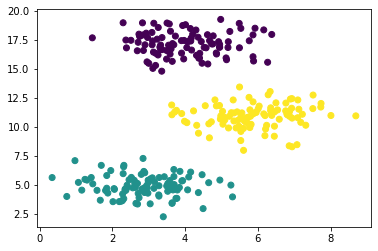

In [2]:
np.random.seed(0)

sample = np.random.randn(300,2)
# alter x, y positions with pos_modifier
pos_modifier = np.random.randint(20,size=(3,2))

# split into 3 groups and modify the position based on pos_modifier
split_sample = np.split(sample,3)
split_sample = [split_sample[i]+pos_modifier[i,:].T for i in range(3)]
mod_sample = np.concatenate(split_sample)

# create labels 
l = np.array([1,2,3])
labels = np.repeat(l,100)
labels

cmaps = ['violet', 'greenyellow', 'orange']

#show datapoints in 2D
plt.scatter(mod_sample[:,0],mod_sample[:,1], c=labels)
plt.show()

In [3]:
fig = go.Figure()
for i in range(len(l)):

    data = mod_sample[labels==l[i],:]
    
    # construct a gaussian kernel density estimate of the distribution
    kde = KernelDensity(bandwidth=0.5, kernel='gaussian')
    kde.fit(data)
    
    Z = np.exp(kde.score_samples(data))
    #Z = Z.reshape(X.shape)
   
    # plot contours of the density
    #levels = np.linspace(0, Z.max(), 15)
    #ax.scatter(Y, Y, Z, levels=levels, colors=cmaps[i])
    fig.add_trace(go.Scatter3d(x=data[:,0], y=data[:,1], z=Z, name=str(l[i]) , mode='markers', 
                               marker=dict(size=3,
                                           color=cmaps[i],  # set color to an array/list of desired values
                                           opacity=0.8))) 
    
py.offline.iplot(fig)